c:\Users\mbunader\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\mbunader\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	max  
0  	100   	-53.3427	-293.489	118.6
1  	67    	32.3294 	-114.599	119.141
2  	81    	99.6315 	-181.431	119.141
3  	85    	98.5694 	-82.542 	119.141
4  	79    	89.5472 	-31.758 	119.141
5  	78    	86.2878 	-80.869 	119.222
6  	75    	100.44  	-81.01  	119.222
7  	82    	82.044  	-81.01  	119.222
8  	75    	97.5489 	-81.01  	119.222
9  	82    	97.109  	-80.476 	119.222
10 	78    	99.6525 	-80.476 	119.222
11 	88    	103.181 	-80.476 	119.222
12 	82    	95.7123 	-80.67  	119.222
13 	88    	112.217 	-80.67  	119.222
14 	74    	91.222  	-80.67  	119.222
15 	81    	82.222  	-80.67  	119.222
Best individual is [82115, 82108, 82014], (119.22200000000001,)
About to call get_materias()
Finished calling get_materias()
Materias seleccionadas:
{'Código': 82115, 'Materia': 'Dirección Estratégica', 'Día': ['Miércoles'], 'Profesor': 'Martel Hernan', 'Puntaje': '99,06', 'Teoria': 'alta', 'Practica': 'baja', 'Tipo': 'Electiva', 'Turno': 'Noche'}
{'Código': 82108, 'Materi

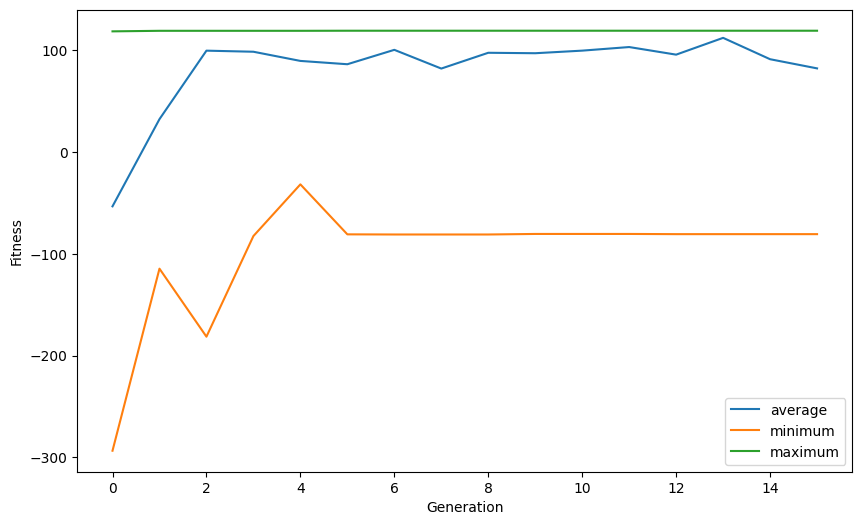

In [5]:
from deap import base, creator, tools, algorithms
import numpy
import pandas as pd
import random

import matplotlib.pyplot as plt

# Carga los datos del JSON
data = pd.read_json('test.json')

# Define el individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_materia", random.choice, data['Código'].tolist())
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_materia, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

dias_libres = ["Martes", "Miércoles", "Jueves", "Viernes"]
preferencia_carga = "Teoria"

# Define la función de aptitud
def evaluar(individual):
    score = 0
    troncal_included = False

    # Crea un conjunto para cada día de la semana
    days = {day: set() for day in dias_libres}

    for code in individual:
        # Busca la materia en los datos cargados del JSON
        materia = data[data["Código"] == code]
        if not materia.empty:

            # Verifica si el día de la materia está en los días libres del estudiante
            for dia in materia["Día"].values[0]:
                if dia not in days or code in days[dia]:
                    # Si el día no está en los días libres, devuelve una aptitud muy baja
                    score -= 150
                else:
                    # Si no, añade la materia al conjunto de ese día
                    days[dia].add(code)

            # Verifica si el día de la materia está en los días libres del estudiante
            if any(dia in dias_libres for dia in materia["Día"].values[0]):
                score += 30

            # Aumenta el puntaje según la preferencia de carga del estudiante
            if preferencia_carga == "Practica":
                if materia["Practica"].values[0] == "alta":
                    score += 10
                if materia["Teoria"].values[0] == "alta":
                    score -= 10
            elif preferencia_carga == "Practica":
                if materia["Practica"].values[0] == "alta":
                    score += 10
                if materia["Teoria"].values[0] == "alta":
                    score -= 10

            # Aumenta el puntaje según el puntaje del profesor
            score += (float(materia["Puntaje"].values[0].replace(",", "."))/10)

            # Verifica si la materia es troncal
            if materia["Tipo"].values[0] == "Troncal":
                troncal_included = True

    # Penaliza si no se incluye una materia troncal
    if not troncal_included:
        score -= 50

    return score,

toolbox.register("evaluate", evaluar)

# Define una función para obtener las materias seleccionadas de un individuo
def get_materias(individual):
    materias_seleccionadas = []
    for code in individual:
        materia = data[data["Código"] == code]
        if not materia.empty:
            materias_seleccionadas.append(materia.to_dict('records')[0])
    return materias_seleccionadas

def has_common_day(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return len(set1.intersection(set2)) > 0

def isValid(individual):
    # Initialize a dictionary to map each day to a list of subject codes
    days = {day: [] for day in dias_libres}
    for subject_code in individual:
        # Convert the subject code to the corresponding subject dictionary
        subject = data[data["Código"] == subject_code].iloc[0].to_dict()
        for day in subject["Día"]:
            # Check if the day is a free day
            if day not in dias_libres:
                return False
            # Check if the day is already occupied
            if days[day]:
                return False
            # If the day is not occupied, schedule the subject on this day
            days[day].append(subject_code)
        # print(days)     
    return True

def mutUnique(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            swap_idx = random.randint(0, len(individual) - 1)
            while swap_idx == i:
                swap_idx = random.randint(0, len(individual) - 1)
            
            # Swap the subjects
            individual[i], individual[swap_idx] = individual[swap_idx], individual[i]
            
            # Check if the new combination is valid
            if not isValid(individual):
                # If the new combination is not valid, undo the swap
                individual[i], individual[swap_idx] = individual[swap_idx], individual[i]
    return individual,

def cxTwoPoint(ind1, ind2):
    size = min(len(ind1), len(ind2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]

    if not isValid(ind1) or not isValid(ind2):
        ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]

    return ind1, ind2

toolbox.register("mate", tools.cxTwoPoint)
# toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(data)-1, indpb=0.1)
toolbox.register("mutate", mutUnique, indpb=0.1)
# toolbox.register("mate", cxUnique)

toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=15, stats=stats, halloffame=hof, verbose=True)

    return pop, log, hof

if __name__ == "__main__":
    pop, log, hof = main()
    best_ind = hof[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    print("About to call get_materias()")
    materias = get_materias(best_ind)
    print("Finished calling get_materias()")
    print("Materias seleccionadas:")
    for materia in materias:
        print(materia)

    # Plotting the performance
    gen = log.select("gen")
    avg = log.select("avg")
    min_ = log.select("min")
    max_ = log.select("max")

    plt.figure(figsize=(10, 6))
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")
    plt.show()